# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Post-Calibration
With access to higher-grade instruments, we start to look at the possibility of post-calibrating the sensors to get more-reliable results.

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report
from src.calibration import run_calibration

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import
In the following cells, we grab the relevant data for the calibration events:
1. Background 2
 - **Start**: datetime(2020,12,28,11,12,0)
 - **End**: datetime(2020,12,28,12,12,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 40, 44, 46, 48]
2. Candle 1
 - datetime(2020,12,30,10,20,0)
 - datetime(2020,12,30,12,25,0)

In [5]:
c = run_calibration.Calibration(datetime(2020,12,28,11,12,0),datetime(2020,12,28,12,12,0))

## Beacons
We have to grab the raw data from the beacons during the various calibration events. We can borrow from the ```porcess_beacon.py``` from the ```make_dataset.py``` source file.

In [ ]:
beacon = c.get_beacon_data([1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 40, 44, 46, 48])

In [3]:
def process_beacon(beacon_list=np.arange(0,51,1),start_time=datetime(2020,12,28),end_time=datetime(2020,12,29),resample_rate=2,verbose=False):
    '''
    Combines data from all sensors on specified beacons

    Returns True if able to save one dataframe that contains all the data at regular intervals in /data/processed directory
    '''

    beacon_data = pd.DataFrame() # dataframe to hold the final set of data
    beacons_folder='../data/raw/bpeace2/beacon'
    # list of all beacons used in the study
    if verbose:
        print('Processing beacon data...\n\tReading for beacon:')
    for beacon in beacon_list:

        # correcting the number since the values <10 have leading zero in directory
        number = f'{beacon:02}'
        if verbose:
            print(f'\t{number}')

        file_count = 0
        beacon_folder=f'{beacons_folder}/B{number}'
        for file in os.listdir(f'{beacon_folder}/adafruit'):
            if file.endswith('.csv'):
                file_count += 1
                
        if file_count > 0:
            beacon_df = pd.DataFrame() # dataframe specific to the beacon

            def import_and_merge(csv_dir,number):
                df_list = []
                for file in os.listdir(csv_dir+'/'):
                    try:
                        # reading in raw data (csv for one day at a time) and appending it to the overal dataframe
                        day_df = pd.read_csv(f'{csv_dir}/{file}',
                                            index_col='Timestamp',parse_dates=True,
                                            infer_datetime_format=True)
                        df_list.append(day_df)

                    except Exception as inst:
                        # for whatever reason, some files have header issues - these are moved to purgatory to undergo triage
                        if verbose:
                            print(f'\t\tIssue encountered while importing {csv_dir}/{file}, skipping...')

                df = pd.concat(df_list).resample(f'{resample_rate}T').mean() # resampling to 2 minute intervals=

                return df

            # Python3 Sensors
            # ---------------
            py3_df = import_and_merge(f'{beacon_folder}/adafruit', number)

            # Changing NO2 readings on beacons without NO2 readings to CO (wiring issues - see Hagen)
            if int(number) > 27:
                if verbose:
                    print('\t\tNo NO2 sensor - removing values')

                py3_df[['CO','T_CO','RH_CO']] = py3_df[['NO2','T_NO2','RH_NO2']]
                py3_df[['NO2','T_NO2','RH_NO2']] = np.nan

            py3_df['CO'] /= 1000 # converting ppb measurements to ppm

            # Python2 Sensors
            # ---------------
            py2_df = import_and_merge(f'{beacon_folder}/sensirion', number)

            # merging python2 and 3 sensor dataframes
            beacon_df = py3_df.merge(right=py2_df,left_index=True,right_index=True,how='outer')

            # getting relevant data only
            beacon_df = beacon_df[start_time:end_time]
            beacon_df.drop(['TVOC', 'eCO2', 'Lux', 'Visible', 'Infrared', "CO","T_CO","RH_CO","T_NO2","RH_NO2",'Temperature [C]','Relative Humidity','PM_N_4','PM_C_4'],axis=1,inplace=True)

            # concatenating the data to the overall dataframe
            beacon_df['Beacon'] = beacon
            beacon_data = pd.concat([beacon_data,beacon_df])

    return beacon_data

## APS
There is previous code that we can adapt to import APS data.

In [4]:
def process_aps(file,resample_rate=2,start_time,end_time):
    '''
    Inputs:
        inverted: boolean that, if True, means that the rows are the size bins and the columns are the timestamps
        file: string holding the reference data

    Returns a dataframe with columns PM1, PM2.5, and PM10 indexed by timestamp
    '''
    raw_data = pd.read_csv('../data/calibration/'+file,skiprows=6)
    df = raw_data.drop(['Sample #','Aerodynamic Diameter'],axis=1)
    date = df['Date']
    sample_time = df['Start Time']
    datetimes = []
    for i in range(len(date)):
        datetimes.append(datetime.strptime(date[i] + ' ' + sample_time[i],'%m/%d/%y %H:%M:%S'))

    df['Timestamp'] = datetimes
    df = df.set_index(['Timestamp'])
    df = df.iloc[:,:54]
    df = df.drop(['Date','Start Time'],axis=1)

    for column in df.columns:
        df[column] = pd.to_numeric(df[column])

    df['PM_1'] = df.iloc[:,:10].sum(axis=1)*1000
    df['PM_2p5'] = df.iloc[:,:23].sum(axis=1)*1000
    df['PM_10'] = df.iloc[:,:42].sum(axis=1)*1000
    
    df_resampled = df.resample(f"{resample_rate}T").mean()
    return df_resampled[start_time:end_time]

## Licor
CO2 data is gathered in a simple, two-column format.

In [5]:
def process_co2(file,resample_rate=2,start_time,end_time):
    """
    
    """
    raw_data = pd.read_csv(f"../data/calibration/{file}",usecols=[0,1],names=["Timestamp","Concentration"])
    raw_data["Timestamp"] = pd.to_datetime(raw_data["Timestamp"],yearfirst=True)
    raw_data.set_index("Timestamp",inplace=True)
    return raw_data.resample(f"{resample_rate}T").mean()

## CAPS

In [6]:
def process_no2(file,resample_rate=2):
    """
    
    """
    raw_data = pd.read_csv(f"../data/calibration/{file}",usecols=["IgorTime","Concentration"])
    # Using igor time (time since Jan 1st, 1904) to get timestamp
    ts = []
    for seconds in raw_data["IgorTime"]:
        ts.append(datetime(1904,1,1) + timedelta(seconds=int(seconds)))
    raw_data["Timestamp"] = ts
    raw_data.set_index("Timestamp",inplace=True)
    raw_data.drop("IgorTime",axis=1,inplace=True)
    # Returning with resampled rate
    return raw_data.resample(f"{resample_rate}T").mean()

## NO

In [7]:
def process_no(file,resample_rate=2):
    """
    
    """
    raw_data = pd.read_csv(f"../data/calibration/{file}",names=["TimeStamp","Concentration"],skiprows=1,index_col=0,parse_dates=True,infer_datetime_format=True)
    return raw_data.resample(f"{resample_rate}T").mean()

## Background 2
One hour event to get background concentrations.

In [19]:
start_time = datetime(2020,12,28,11,12,0)
end_time = datetime(2020,12,28,12,12,0)

### Beacon

In [18]:
beacon_b2 = process_beacon(beacon_list=[1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 40, 44, 46, 48],
                           start_time=start_time, end_time=end_time)

### Reference Instruments
All data are saved as dataframes in a dictionary indexed by the pollutant type

In [9]:
d = "12282020"
ref_b2 = {}
for pollutant, f in zip(["pm_count","pm_number","pm_concentration","no","no2","co2"],[process_aps,process_aps,process_aps,process_no,process_no2,process_co2]):
    ref_b2[pollutant] = f(f"{pollutant}_{d}.csv")

# Base Visualization
Visually comparing measurements

In [10]:
beacon_b2.columns

Index(['NO2', 'CO2', 'PM_N_0p5', 'PM_N_1', 'PM_N_2p5', 'PM_N_10', 'PM_C_1',
       'PM_C_2p5', 'PM_C_10', 'Beacon'],
      dtype='object')

In [20]:
def plot_time_series(ref_data,beacon_data):
    """
    Plots reference and beacon data as a time series
    """
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(ref_data.index,ref_data.iloc[:,0].values,linewidth=3,color="black",zorder=100)
    for bb in beacon_data["Beacon"].unique():
        if bb < 10:
            m = "s"
        elif bb < 20:
            m = "^"
        elif bb < 30:
            m = "P"
        elif bb <40:
            m = "*"
        else:
            m = "o"
            
        data_by_bb = beacon_data[beacon_data["Beacon"] == bb]
        data_by_bb.drop("Beacon",axis=1,inplace=True)
        data_by_bb.dropna(inplace=True)
        
        if len(data_by_bb) > 0:
            ax.plot(data_by_bb.index,data_by_bb.iloc[:,0].values,marker=m,label=bb)
        
    ax.legend(bbox_to_anchor=(1,1))
        
    plt.show()
    plt.close()

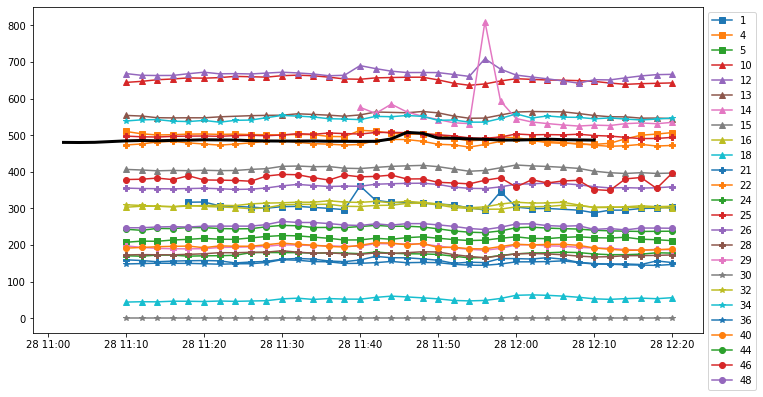

In [12]:
plot_time_series(ref_b2["co2"],beacon_b2[["CO2","Beacon"]])

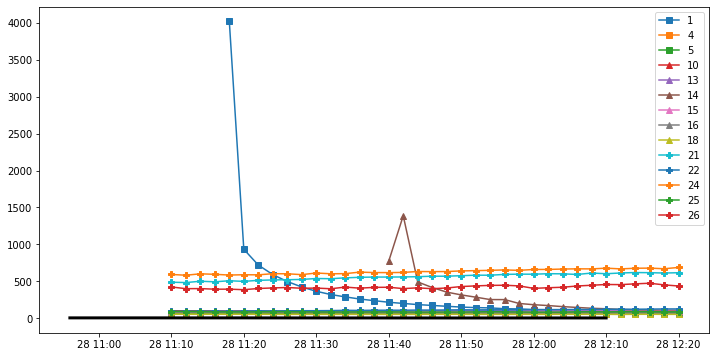

In [13]:
plot_time_series(ref_b2["no2"],beacon_b2[["NO2","Beacon"]])

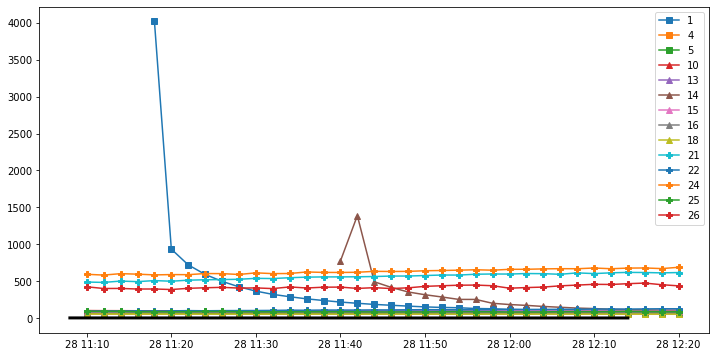

In [14]:
plot_time_series(ref_b2["no"],beacon_b2[["NO2","Beacon"]])

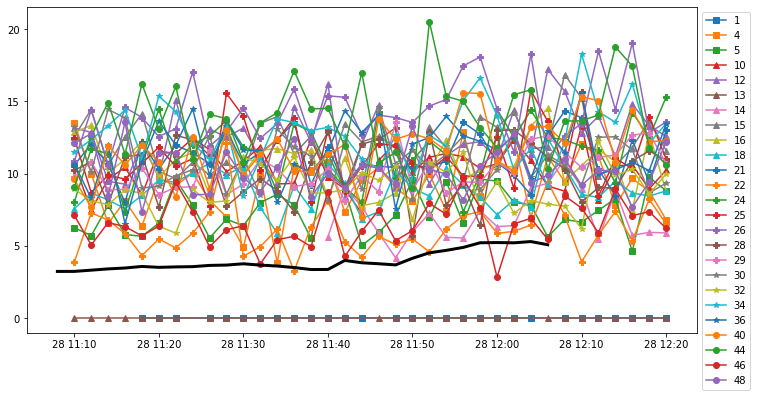

In [15]:
plot_time_series(ref_b2["pm_concentration"][["PM_2p5"]],beacon_b2[["PM_C_2p5","Beacon"]])

# Analysis

In [16]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Linear Regression
We can run linear regression for each of the beacons to determine how we can best correct our data.

In [ ]:

# Training data
